# 1D Water Isotope Diffusion Model

Liam Kirkpatrick

Feb 15, 2024

IBIS project on water isotope diffusion

This model integrates added functions, including the ability to vary ice thickness and temperature over the course of the mdoel run.

### Import packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable # allows adding colorbar on line plot

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Define Forward Euler scheme algorithm for solving diffusion equation

Here I draw from: https://hplgit.github.io/fdm-book/doc/pub/diffu/pdf/diffu-4print.pdf, https://zsylvester.github.io/post/diffusion_equation/, and https://www.uni-muenster.de/imperia/md/content/physik_tp/lectures/ws2016-2017/num_methods_i/heat.pdf. However, I end up choosing to write my own function here.


In [3]:
def diffusion(t,z,z0,zmax,I,T,thin):
# function
#     Computes diffusion using a 1D euler method approach
# Inputs:
#     t    - vectors of time for the run (UNITS: years)
#     z    - vector of vertical (1D) grid spacing (UNITS: m)
#     z0   - boundary condition, upper side (UNITS: permille)
#     zmax - boundary condition, lower side (UNITS: permille)
#     I    - vector of inital condition (UNITS: permille)
#     T    - Temperature (K)
#     thin - vector of thinning of layers. 
# Outputs:
#     T    - matrix of results, where first axis is time and seccond axis is vertical grid (UNITS: permille)

    
    # find dt (convert to secconds)
    dt = (t[1]-t[0]) * 365.25 * 24 * 60 * 60
    
    # find number of timesteps and distance steps
    nt = len(t)
    nz = len(z)
        
    # create matrix of results. Set full of zeros for now
    ISO = np.zeros((nt,nz))
    
    # set first line of matrix to initial conditions, set edges to boundary conditions
    ISO[0,:] = I
    ISO[0,0] = z0
    ISO[0,-1] = zmax
    
    # loop through all timesteps (from 1:end). We don't need to run first timestep as that's the inital conditions
    for j in range(1,nt):
        
        # Calculate dz at this timestep. This might change due to thinning.
        dz = (z[1]-z[0]) * thin[j]
        
        # Calculate diffusion coefficent (following Gkinis et al., 2014)
        D = 9.2 * 10**(-4) * math.exp(-7186/T[j]) # units m^2/s
        
        # check stability
        if dt > (0.5*dz**2 / D):
            print("*******************************")
            print("*******************************")
            print("            UNSTABLE           ")
            print("*******************************")
            print("*******************************")
        
        # calculate diffusion number
        d = D * dt / (dz**2)
        
        # loop through all grid points (except left/right side)
        for i in range(1,nz-1):
            
            # solve for gridpoint at this time step
                # this draws on this point, the point above, and the point below at the prior timestep
            ISO[j,i] = ISO[j-1,i] + d * (ISO[j-1,i-1] - 2*ISO[j-1,i] + ISO[j-1,i+1])
            
        # set endpoints
        ISO[j,0] = z0
        ISO[j,-1] = zmax
        
    return(ISO)

### Define initial and boundary conditions, time vector, etc


In [4]:
# set time vector
years = 1*10**6
resolution = 5
t = np.linspace(0,years,round(years/resolution)+1)

# set boundary conditions (per mille)
z0 = -50
zmax = -50

# set (inital) space vector. Units of m. Ideal to keep AT LEAST 1cm resolution (so 100x).
meters = 1 # total depth range of sample
gridspace = 0.01 # model resultion, m
z = np.linspace(0,meters,round(meters/gridspace)+1) # make vector. Have to round number of samples to whole number.

# set inital conditions
period_sin = 0.25 # MUST BE EVENLY DIVIDABLE BY GRIDSPACE!
sin_amp = 10
I = np.ones(len(z)) * (z0+zmax)/2
for i in range(len(I)):
    I[i] = I[i] + sin_amp * math.sin(i/(period_sin/gridspace)*2*math.pi)

## Example of running this for multiple sets of conditions at once

We'll run this for two temperature scenarios - one flat at 240 K and one cooling linearly from 230K to 240K over 1 million years.

We'll also run for two thinning scenarios - one holding flat at 1m thick for the duration, and the other thinning from 1m to 0.5m over 1 million years.

2 temperature scenarios times two thinning scenarios is 4 runs total.

In [5]:
#+++++++++++++++++++++++++++++++++++++++++
# First, set up our two temperature scenarios



# now make a list of these two scenarios
T_list = [np.linspace(243,243,len(t)),
        np.linspace(253,243,len(t)),
         np.linspace(263,243,len(t))]

# now make a list with a name for each scenario
T_names = ["Constant 243K","Cooling 253K to 243K","Cooling 263K to 243K"]

#+++++++++++++++++++++++++++++++++++++++++
# Now, repeat the same thing for thinning
# first set start/end thinning for the first scenario
thin01 = 1
thinend1 = 1
# next set start/end thinning for the second scenario
thin02 = 5
thinend2 = 1
# now make a list of these two scenarios
thin_list = [np.linspace(thin01,thinend1,len(t)),
             np.linspace(thin02,thinend2,len(t))]
# now make a list with a name for each scenario

thin_names = ["No Thinning","Thinning 5m to 1m"]


## Now Run four trials

Running temperature scenario 1 of 3, thinning scenario 1 of 2


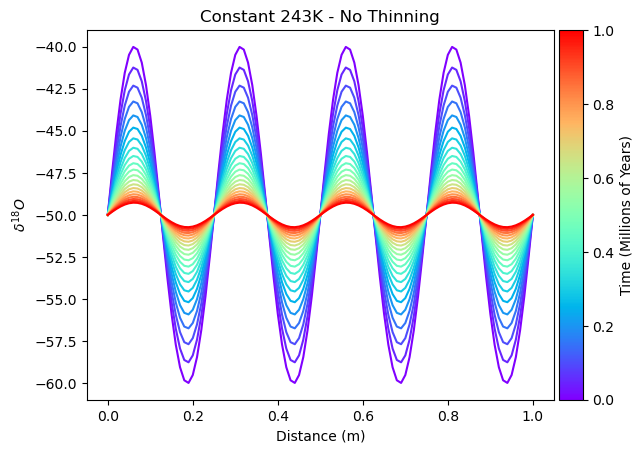

Running temperature scenario 1 of 3, thinning scenario 2 of 2


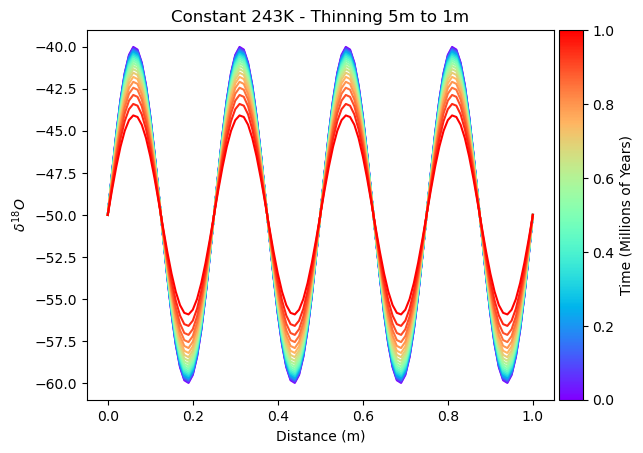

Running temperature scenario 2 of 3, thinning scenario 1 of 2


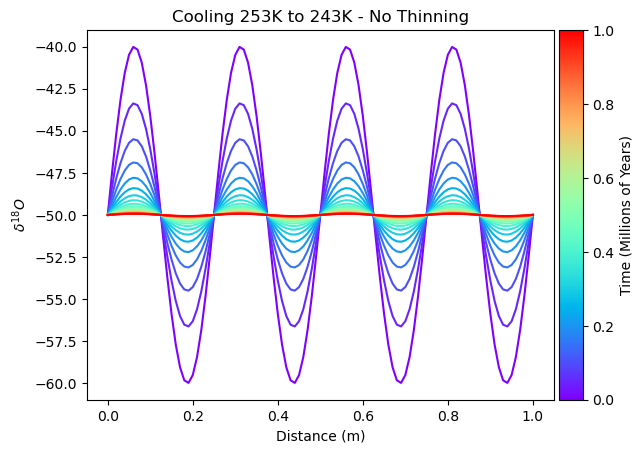

Running temperature scenario 2 of 3, thinning scenario 2 of 2


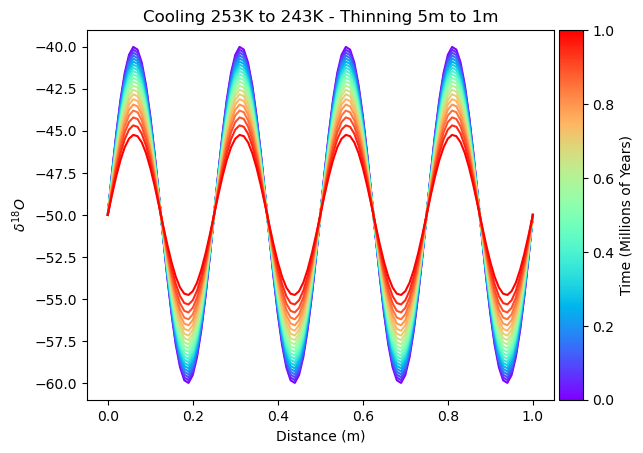

Running temperature scenario 3 of 3, thinning scenario 1 of 2


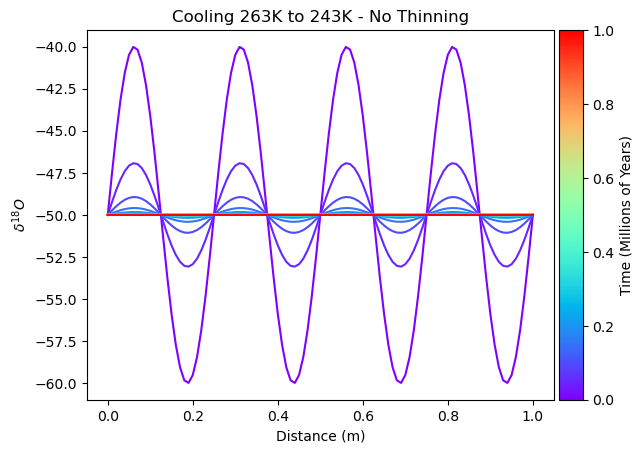

Running temperature scenario 3 of 3, thinning scenario 2 of 2


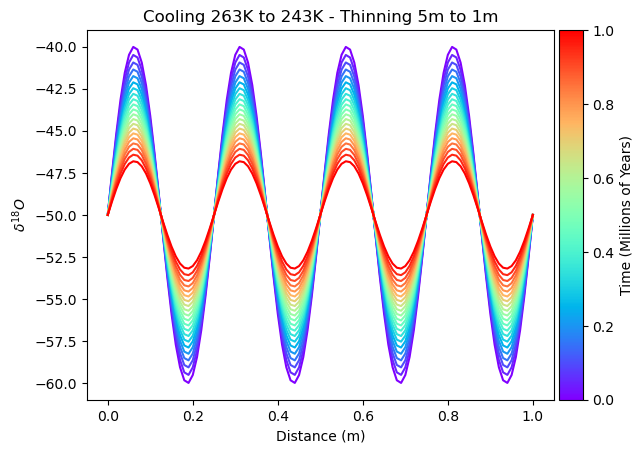

In [6]:
# make a matrix to save the amplitude data from each track.
# The matrix will be m x n large, where m is the number of T scenarios and n is the number of thinning scenarios
m = len(T_list)
n = len(thin_list)
amplitude = np.zeros((m,n))*np.NaN

# loop through our temperature scenarios.
# we do this by looping through i
for i in range(0,len(T_list)):
    
    #loop through our thinning scenarios
    for j in range(0,len(thin_list)):
        
        print("Running temperature scenario "+str(i+1)+" of "+str(len(T_list))+
              ", thinning scenario "+str(j+1)+" of "+str(len(thin_list)))
    
        run = diffusion(t,z,z0,zmax,I,T_list[i],thin_list[j])

        # save amplitude
        amplitude[i,j] = max(run[-1,:]) - min(run[-1,:])
        
        # make figure
        fig, axs = plt.subplots(dpi=100)
        axs.set_ylabel(r'$\delta^{18}O$')
        axs.set_xlabel('Distance (m)')
        axs.set_title(T_names[i]+' - '+thin_names[j])

        # set colormap and add colorbar
        norm = matplotlib.colors.Normalize(vmin=np.min(t)*10**-6,vmax=np.max(t)*10**-6)
        cmap = matplotlib.colormaps.get_cmap('rainbow')
        s_m = matplotlib.cm.ScalarMappable(cmap=cmap,norm=norm)
        s_m.set_array([])
        divider = make_axes_locatable(axs)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(s_m,cax=cax,label='Time (Millions of Years)')

        # Plot all time steps
        for k in range(0,len(t),10**4): # loop through all time steps
        
            # plot give time step. Shade by time.
            axs.plot(z,run[k,:],color=cmap(k/len(t)))
            
        # save figure.
        # Requires you to set up a folder called "figures" in the folder where you have the script stored
        # includes descriptor in filename
        fname='figures/fig-'+T_names[i]+'-'+thin_names[j]+'.png'
        fig.savefig(fname)
        plt.show()


# Plot 

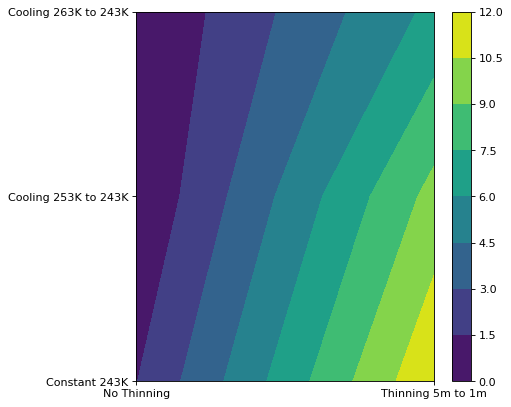

In [17]:
# Make an amplitude plot

# make figure
fig,axs = plt.subplots(figsize=(6,6),dpi=80)

cax = axs.contourf(amplitude)
axs.set_xticks(np.linspace(0,len(thin_names)-1,len(thin_names)))
axs.set_xticklabels(thin_names)
axs.set_yticks(np.linspace(0,len(T_names)-1,len(T_names)))
axs.set_yticklabels(T_names)
fig.colorbar(cax)

array([0., 1.])